## 01. Install Dependencies

In [3]:
# !pip install pandas numpy matplotlib scikit-learn tensorflow ta joblib

import zipfile
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import ta

## 02. Extract ZIP

In [4]:
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("nifty50_data")

## 03. Load and preprocess RELIANCE data

In [5]:
df = pd.read_csv('nifty50_data/RELIANCE.csv')
df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']].dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

## 04. Feature Engineering

In [6]:
df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['SMA_50'] = ta.trend.sma_indicator(df['Close'], window=50)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['MACD'] = ta.trend.macd_diff(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df.dropna(inplace=True)

features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD']
data = df[features].values

## 05. Normalize

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## 06. Dataset creation

In [8]:
def create_dataset(dataset, time_step=60):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step), :])
        dataY.append(dataset[i + time_step, 0])  # Predict 'Close'
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 07. Build and Train LSTM

In [9]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0153 - val_loss: 0.0015
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 8.4844e-04
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 8.6243e-04
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 9.6595e-04
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.9753e-04 - val_loss: 8.0030e-04
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - val_loss: 6.4770e-04
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - val_loss: 6.5550e-04
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9905e-04 - val_loss: 9.4953e-04
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 7.4293e-04
Epoch 12/50
65/65 ━━━━━

## 08. Save model and 100 rows for manual input

In [15]:
model.save("LSTM_Model.h5")
df.tail(100)[['Close']].to_csv("reliance_tail_100.csv", index=False)

## 09. Plot loss

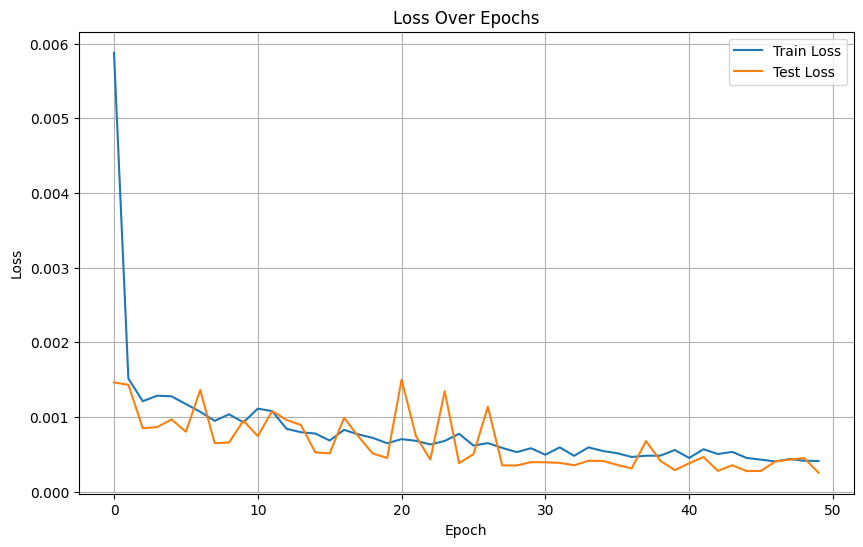

In [12]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 10. Evaluate on test set

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


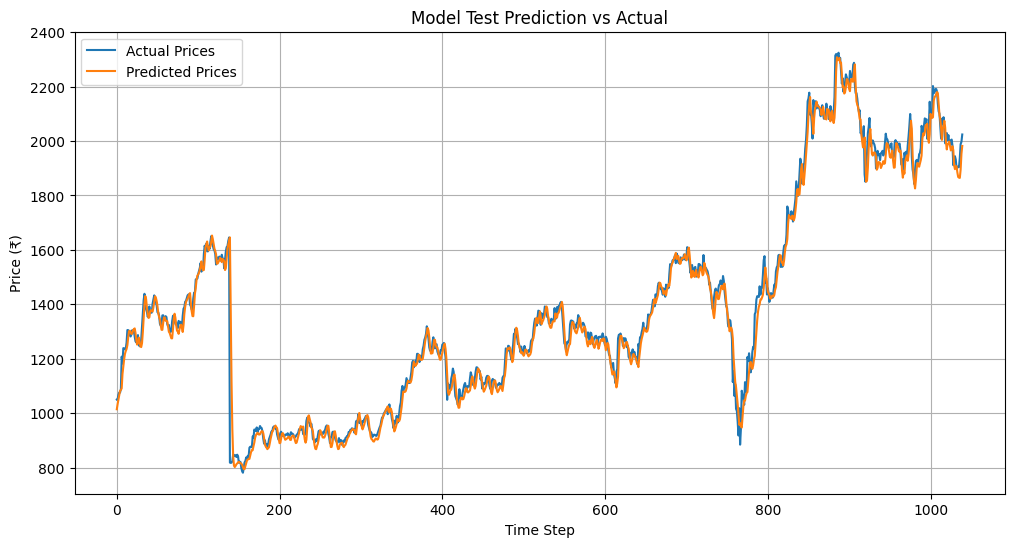

In [13]:
y_pred_scaled = model.predict(X_test)

dummy_pred = np.zeros((len(y_pred_scaled), len(features)))
dummy_pred[:, 0] = y_pred_scaled[:, 0]
predicted_prices = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_actual = np.zeros((len(y_test), len(features)))
dummy_actual[:, 0] = y_test
actual_prices = scaler.inverse_transform(dummy_actual)[:, 0]

plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Model Test Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.show()

## 11. Manual input prediction

In [22]:
manual_prices = [
2914.50, 2919.10, 2928.95, 2927.55, 2933.15, 2958.25, 2954.65, 2937.00, 2942.85, 2918.40,
2885.00, 2891.70, 2909.95, 2911.35, 2908.50, 2883.80, 2877.85, 2855.30, 2859.10, 2883.15,
2882.50, 2905.80, 2931.30, 2923.65, 2933.85, 2908.30, 2904.90, 2921.40, 2942.30, 2960.50,
2959.00, 2981.15, 2973.45, 2991.00, 3015.80, 3020.95, 3029.95, 3042.80, 3033.20, 3036.00,
3060.70, 3051.85, 3025.00, 3034.40, 3041.50, 3019.20, 3030.75, 3039.80, 3045.00, 3032.50,
3021.15, 3028.90, 3040.10, 3033.85, 3051.05, 3065.70, 3084.35, 3088.05, 3091.50, 3105.20

]

tail_df = pd.read_csv("reliance_tail_100.csv")
combined_df = pd.concat([tail_df, pd.DataFrame({'Close': manual_prices})], ignore_index=True)

combined_df['SMA_20'] = ta.trend.sma_indicator(combined_df['Close'], window=20)
combined_df['SMA_50'] = ta.trend.sma_indicator(combined_df['Close'], window=50)
combined_df['RSI'] = ta.momentum.rsi(combined_df['Close'], window=14)
combined_df['MACD'] = ta.trend.macd_diff(combined_df['Close'], window_slow=26, window_fast=12, window_sign=9)

manual_input = combined_df[features].tail(60).values
scaled_manual_input = scaler.transform(manual_input)
X_manual = scaled_manual_input.reshape(1, 60, len(features))

manual_pred_scaled = model.predict(X_manual)

dummy = np.zeros((1, len(features)))
dummy[0, 0] = manual_pred_scaled[0, 0]
manual_pred_price = scaler.inverse_transform(dummy)[0, 0]

print(f"\n🟢 Predicted Next Closing Price (Manual Input): ₹{manual_pred_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

🟢 Predicted Next Closing Price (Manual Input): ₹3073.88
